In [1]:
import os
import json
import math
import pandas as pd
import seaborn as sns
import redis
from itertools import chain
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from random import shuffle
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']#['retina']
sns.set_style("whitegrid")
pd.options.display.max_columns = None

/storage/jecummin/libraries/conda/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Load experiment video data from json

In [2]:
experiment_name = 'nsd_experiment'
video_data_path = f"experiment/public/experiment_data/video_data_{experiment_name}.json"
with open(video_data_path) as f:
    video_data = json.load(f)

for v in video_data:
    v["objectnet"] = True if v['image'][0] != 'I' else False

video_data = pd.DataFrame(video_data)

In [3]:
video_to_num = {}
for video in tqdm(video_data['video'].unique()):
    video_num = video_data[video_data['video'] == video].index[0]
    video_to_num[video] = video_num
    

100%|██████████| 4422/4422 [00:07<00:00, 621.82it/s]


## Load test subject responses from redis

In [6]:
# depending on your environment setup, you may not be able to get environment variables
# in the notebook. If not, just manually set these variables
environment = os.environ
EXPERIMENT_HOST = environment.get("EXPERIMENT_HOST")
EXPERIMENT_PORT = environment.get("EXPERIMENT_PORT")
REDIS_HOST = environment.get("REDIS_HOST")
REDIS_PORT = environment.get("REDIS_PORT")
REDIS_DB = environment.get("REDIS_DB")
REDIS_PASSWORD = environment.get("REDIS_PASSWORD")

In [40]:
load_from_db = True
all_workers = set()
if load_from_db:
    r = redis.Redis(host=REDIS_HOST,
                port=REDIS_PORT,
                password=REDIS_PASSWORD,
                charset="utf-8",
                decode_responses=True, 
                db=REDIS_DB)
    link_ids = r.smembers(experiment_name)
    video_responses = {}
    responses = {}
    worker_ids = {id: [] for id in link_ids}
    worker_to_link = {}
    for key in r.keys():
        if key.endswith(':responses'):
            all_workers.add(key[19:-10])
            if key[:8] not in link_ids:
                continue
            worker_ids[key[:8]].append(key[19:-10])
            if not worker_to_link.get(key[19:-10]):
                worker_to_link[key[19:-10]] = []
            worker_to_link[key[19:-10]].append(key[:8])
    
    for worker in worker_to_link:
        for link in worker_to_link[worker]:
            r.sadd(worker + ':links', link)
        
    all_assignments = set()
    for link_id in link_ids:
       
        for worker_id in worker_ids[link_id]:
            if not responses.get(worker_id):
                responses[worker_id] = []
            response = r.smembers(link_id+":worker_id:" + worker_id + ":responses")
            trials = []
            trial = list(response)[0]
            assignment_id = r.hgetall(link_id+":worker_id:" + worker_id +":response:"+trial).get('assignment_id')

            if len(response) > 0:
                for trial in list(response):
                    trials.append(r.hgetall(link_id+":worker_id:" + worker_id +":response:"+trial))
            all_assignments.add(assignment_id)

            responses[worker_id].extend(trials)
        
    response_data = pd.DataFrame(list(chain.from_iterable(responses.values())))
    response_data['video_num'] = response_data['video_num'].map(video_to_num)
    response_data['response_time'] = response_data['response_time'].astype(int)/1000
    del response_data['video']
    response_data = response_data.set_index('video_num').join(video_data)
    
    
# maintain a list of all workers
with open(f'worker_ids_{experiment_name}.json', 'w') as f:
    json.dump(list(all_workers), f)
    print(len(all_workers))



3


In [41]:
response_data.trial_num = response_data.trial_num.astype(int)
response_data = response_data.sort_values("trial_num")
response_data.dropna(how='any', inplace=True)
        
        
# convert frame counts to ms
def get_adjusted_duration(timing):
    return round(timing / 60 * 1000)
response_data['image_duration'] = [get_adjusted_duration(a) for a in response_data['image_duration']]

# mark correctness of responses
response_data = response_data.fillna(0)
response_data['response'] = [r.replace(" ", "_") for r in response_data['response']]
response_data['is_correct'] = [(1 if a==True else 0) for a in (response_data['response']==response_data['label'])]
response_data['response_options'] = [tuple(l) for l in response_data['response_options']]
                 
response_data

,color_depth,response_time,view_distance,px2mm,user_agent,worker_id,window_height_px,link_id,trial_num,IP,screen_height_px,assignment_id,window_width_px,video_height,total_elapsed_time,response,screen_width_px,device_pixel_ratio,hit_id,video,image,label,response_options,mask_type,mask,cross_duration,image_duration,mask_duration,white_end_frames,objectnet,is_correct
video_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3309,30,11.018,505.19,5.0313,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,dmayo,1728,402nnxrk,0,::ffff:73.61.65.45,1117,ASSIGNMENT_ID,1728,355,400795,horse,1728,2,HIT_ID,shared0695_nsd50812_phase_90_9_30_30.mp4,shared0695_nsd50812.png,horse,"(airplane, banana, bear, bed, bicycle, bird, b...",color_phase,shared0695_nsd50812_phase_scramble.png,90,150,30,30,True,1
9093,30,61.549,127.55,6.4836,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,WORKER_ID,1728,w6866ejs,0,::ffff:192.152.118.97,1117,ASSIGNMENT_ID,1728,116,99044,vase,1728,2,HIT_ID,shared0199_nsd16656_phase_90_9_30_30.mp4,shared0199_nsd16656.png,zebra,"(airplane, banana, bear, bed, bicycle, bird, b...",color_phase,shared0199_nsd16656_phase_scramble.png,90,150,30,30,True,0
6835,30,4.486,553.97,5.0053,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,jecummin,1386,pghomgsm,0,::ffff:209.6.132.215,900,ASSIGNMENT_ID,1386,388,105306,kite,1440,2,HIT_ID,shared0979_nsd70765_phase_90_3_30_30.mp4,shared0979_nsd70765.png,kite,"(airplane, banana, bear, bed, bicycle, bird, b...",color_phase,shared0979_nsd70765_phase_scramble.png,90,50,30,30,True,1
8015,30,9.067,553.97,5.0053,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,jecummin,1386,pghomgsm,1,::ffff:209.6.132.215,900,ASSIGNMENT_ID,1386,388,136138,banana,1440,2,HIT_ID,shared0452_nsd33814_phase_90_600_30_30.mp4,shared0452_nsd33814.png,banana,"(airplane, banana, bear, bed, bicycle, bird, b...",color_phase,shared0452_nsd33814_phase_scramble.png,90,10000,30,30,True,1
10283,30,4.649,399.64,5.2517,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,WORKER_ID,1728,w6866ejs,1,::ffff:73.61.65.45,1117,ASSIGNMENT_ID,1728,293,45486,bear,1728,2,HIT_ID,shared0705_nsd51746_phase_90_600_30_30.mp4,shared0705_nsd51746.png,bear,"(airplane, banana, bear, bed, bicycle, bird, b...",color_phase,shared0705_nsd51746_phase_scramble.png,90,10000,30,30,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,30,8.978,553.97,5.0053,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,jecummin,1386,pghomgsm,46,::ffff:209.6.132.215,900,ASSIGNMENT_ID,1386,388,754290,bicycle,1440,2,HIT_ID,shared0032_nsd04613_phase_90_1_30_30.mp4,shared0032_nsd04613.png,remote,"(airplane, banana, bear, bed, bicycle, bird, b...",color_phase,shared0032_nsd04613_phase_scramble.png,90,17,30,30,True,0
10079,30,3.769,505.19,5.0313,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,dmayo,1728,402nnxrk,47,::ffff:73.61.65.45,1117,ASSIGNMENT_ID,1728,355,1174220,bear,1728,2,HIT_ID,shared0517_nsd39096_phase_90_600_30_30.mp4,shared0517_nsd39096.png,bear,"(airplane, banana, bear, bed, bicycle, bird, b...",color_phase,shared0517_nsd39096_phase_scramble.png,90,10000,30,30,True,1
5753,30,3.202,553.97,5.0053,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,jecummin,1386,pghomgsm,47,::ffff:209.6.132.215,900,ASSIGNMENT_ID,1386,388,773161,clock,1440,2,HIT_ID,shared0773_nsd56155_phase_90_600_30_30.mp4,shared0773_nsd56155.png,clock,"(airplane, banana, bear, bed, bicycle, bird, b...",color_phase,shared0773_nsd56155_phase_scramble.png,90,10000,30,30,True,1


In [42]:
"""
Finds list of workers who have less than 60% accuracy at 10s image duration. You should strongly consider ignoring
these results and reposting the assignments for replacement by other workers. We do not necessarily recommend rejecting 
workers assignments on MTurk because that can get complicated to do fairly, but we have set up the backend such that you
can block these workers from doing more tasks and mark their assignments for replacement.
"""
worker_accuracies = response_data.groupby(['worker_id', 'image_duration']).mean()['is_correct']
workers_to_block = list(set([x[0] for x in worker_accuracies[worker_accuracies < 0.6].index if x[1] == 10_000]))
print('Workers with low 10s accuracy', len(workers_to_block))

# adds workers to blocked list
for worker in workers_to_block:
    r.sadd('blocked_worker_ids', worker)
    
    
# marks all assignments completed by blocked workers for replacement by new workers
assignments_to_replace = response_data[response_data['worker_id'].isin(workers_to_block)]['assignment_id'].unique()
for assignment in assignments_to_replace:
    r.sadd('assignments_to_replace', assignment)
    
    
response_data = response_data[~response_data['worker_id'].isin(workers_to_block)]
response_data.to_csv(f'{experiment_name}_results.csv') # save experiment to csv

Workers with low 10s accuracy 0


In [43]:
"""
Keep track of how many unique workers have completed tasks for each link. 
This should give you a good idea how close you are to getting the whole
complement of responses and which links you need to repost with how
many new assignments.
"""
link_counts = response_data.groupby(['link_id']).nunique()['worker_id']
link_counts

link_id
402nnxrk    1
pghomgsm    1
w6866ejs    1
Name: worker_id, dtype: int64

In [44]:
"""
To get more explicit information about which results are missing, take a 
look at how many times each image has been seen at each timing. Images
with fewer responses at a given timing than they should have indicate
assignments that are yet to be completed or need replacement.
"""
num_workers_per_image_per_duration = #TODO
exp_image_count = response_data.groupby(["image_duration", "image"]).count()["trial_num"] #TODO
need_more_responses = list(set([x[1] for x in exp_image_count[exp_image_count < num_workers_per_image_per_duration].index]))
need_more_responses

SyntaxError: invalid syntax (<ipython-input-44-68889004e204>, line 7)

<Axes: xlabel='image_duration', ylabel='is_correct'>

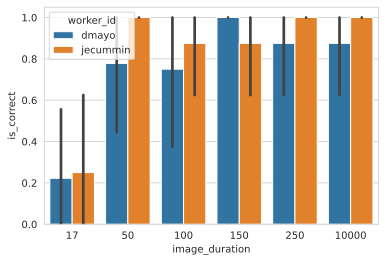

In [45]:
# get accuracy plot
sns.barplot(data=response_data, x='image_duration', y='is_correct')

In [46]:
response_data[response_data['image_duration'] == 10000]

,color_depth,response_time,view_distance,px2mm,user_agent,worker_id,window_height_px,link_id,trial_num,IP,screen_height_px,assignment_id,window_width_px,video_height,total_elapsed_time,response,screen_width_px,device_pixel_ratio,hit_id,video,image,label,response_options,mask_type,mask,cross_duration,image_duration,mask_duration,white_end_frames,objectnet,is_correct
video_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8015,30,9.067,553.97,5.0053,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,jecummin,1386,pghomgsm,1,::ffff:209.6.132.215,900,ASSIGNMENT_ID,1386,388,136138,banana,1440,2,HIT_ID,shared0452_nsd33814_phase_90_600_30_30.mp4,shared0452_nsd33814.png,banana,"(airplane, banana, bear, bed, bicycle, bird, b...",color_phase,shared0452_nsd33814_phase_scramble.png,90,10000,30,30,True,1
1949,30,9.660,505.19,5.0313,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,dmayo,1728,402nnxrk,1,::ffff:73.61.65.45,1117,ASSIGNMENT_ID,1728,355,425231,pizza,1728,2,HIT_ID,shared0657_nsd47688_phase_90_600_30_30.mp4,shared0657_nsd47688.png,pizza,"(airplane, banana, bear, bed, bicycle, bird, b...",color_phase,shared0657_nsd47688_phase_scramble.png,90,10000,30,30,True,1
1139,30,5.636,553.97,5.0053,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,jecummin,1386,pghomgsm,7,::ffff:209.6.132.215,900,ASSIGNMENT_ID,1386,388,225436,dog,1440,2,HIT_ID,shared0322_nsd25285_phase_90_600_30_30.mp4,shared0322_nsd25285.png,dog,"(airplane, banana, bear, bed, bicycle, bird, b...",color_phase,shared0322_nsd25285_phase_scramble.png,90,10000,30,30,True,1
15275,30,7.665,553.97,5.0053,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,jecummin,1386,pghomgsm,8,::ffff:209.6.132.215,900,ASSIGNMENT_ID,1386,388,252838,cake,1440,2,HIT_ID,shared0035_nsd04769_phase_90_600_30_30.mp4,shared0035_nsd04769.png,cake,"(airplane, banana, bear, bed, bicycle, bird, b...",color_phase,shared0035_nsd04769_phase_scramble.png,90,10000,30,30,True,1
17867,30,4.870,553.97,5.0053,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,jecummin,1386,pghomgsm,10,::ffff:209.6.132.215,900,ASSIGNMENT_ID,1386,388,282524,frisbee,1440,2,HIT_ID,shared0405_nsd30408_phase_90_600_30_30.mp4,shared0405_nsd30408.png,frisbee,"(airplane, banana, bear, bed, bicycle, bird, b...",color_phase,shared0405_nsd30408_phase_scramble.png,90,10000,30,30,True,1
4355,30,6.429,505.19,5.0313,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,dmayo,1728,402nnxrk,13,::ffff:73.61.65.45,1117,ASSIGNMENT_ID,1728,355,707230,surfboard,1728,2,HIT_ID,shared0381_nsd28525_phase_90_600_30_30.mp4,shared0381_nsd28525.png,surfboard,"(airplane, banana, bear, bed, bicycle, bird, b...",color_phase,shared0381_nsd28525_phase_scramble.png,90,10000,30,30,True,1
25325,30,4.845,553.97,5.0053,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,jecummin,1386,pghomgsm,20,::ffff:209.6.132.215,900,ASSIGNMENT_ID,1386,388,422123,sink,1440,2,HIT_ID,shared0124_nsd10394_phase_90_600_30_30.mp4,shared0124_nsd10394.png,sink,"(airplane, banana, bear, bed, bicycle, bird, b...",color_phase,shared0124_nsd10394_phase_scramble.png,90,10000,30,30,True,1
14627,30,7.773,505.19,5.0313,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,dmayo,1728,402nnxrk,24,::ffff:73.61.65.45,1117,ASSIGNMENT_ID,1728,355,824110,cow,1728,2,HIT_ID,shared0676_nsd49157_phase_90_600_30_30.mp4,shared0676_nsd49157.png,cow,"(airplane, banana, bear, bed, bicycle, bird, b...",color_phase,shared0676_nsd49157_phase_scramble.png,90,10000,30,30,True,1
20291,30,23.070,505.19,5.0313,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,dmayo,1728,402nnxrk,30,::ffff:73.61.65.45,1117,ASSIGNMENT_ID,1728,355,944675,bear,1728,2,HIT_ID,shared0679_nsd49481_phase_90_600_30_30.mp4,shared0679_nsd49481.png,teddy_bear,"(airplane, banana, bear, bed, bicycle, bird, b...",color_phase,shared0679_nsd49481_phase_scramble.png,90,10000,30,30,True,0
